<a href="https://colab.research.google.com/github/nallinwerlang/ML/blob/main/01_ARTIGO_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DETECÇÃO DE SMURFING

## Pré-processamento (ETL Process - Load Data)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
dados = pd.read_csv("/content/drive/MyDrive/ufsc/ML/Artigo/EXTRATO_DETALHADO_ALT.csv", delimiter= ';')
dados.head()


,NOME_TITULAR,DESCRICAO_LANCAMENTO,CNAB,DATA_LANCAMENTO,VALOR_TRANSACAO,NATUREZA_LANCAMENTO,SMURFING
0,ANDREZA RAMOS DA ROSA,DEPOSITO EM DINHEIRO NO CAIXA,220,11/01/2010,"1.000,00",C,1
1,ANDREZA RAMOS DA ROSA,DEPOSITO EM DINHEIRO NO CAIXA,220,11/01/2010,"1.000,00",C,1
2,ANDREZA RAMOS DA ROSA,CREDITO DE SALARIO,205,05/02/2010,"440,73",C,0
3,ANDREZA RAMOS DA ROSA,TRANSF SALDO C/SAL P/ CC,117,05/02/2010,"440,73",D,0
4,ANDREZA RAMOS DA ROSA,CREDITO DE SALARIO,205,05/03/2010,"455,28",C,0


##Análise do conjunto de dados

In [7]:
NATUREZA_LANCAMENTO = dados['NATUREZA_LANCAMENTO'].value_counts()
NATUREZA_LANCAMENTO

D    4218
C    2681
Name: NATUREZA_LANCAMENTO, dtype: int64

Text(0, 0.5, 'Porcentagem (%)')

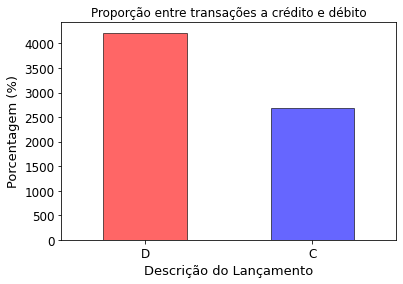

In [91]:
import matplotlib.pyplot as plt

NATUREZA_LANCAMENTO.plot.bar(color=['red', 'blue'], ec='k', alpha=0.6)
plt.title('Proporção entre transações a crédito e débito')
plt.xticks(rotation = 360, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Descrição do Lançamento', fontsize=13)
plt.ylabel('Porcentagem (%)', fontsize=13)

In [ ]:
CNAB = dados['CNAB'].value_counts(normalize=True)*100
CNAB

In [93]:
SMURFING = dados['SMURFING'].value_counts()
SMURFING

0    6471
1     428
Name: SMURFING, dtype: int64

Text(0, 0.5, 'Porcentagem (%)')

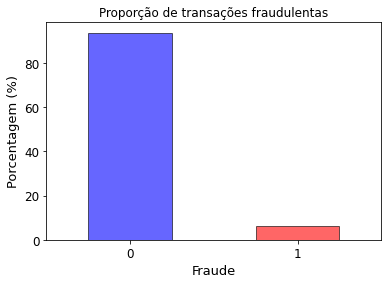

In [94]:
SMURFING = dados['SMURFING'].value_counts(normalize=True)*100

SMURFING.plot.bar(color=['blue', 'red'], ec='k', alpha=0.6)
plt.title('Proporção de transações fraudulentas')
plt.xticks(rotation = 360, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Fraude', fontsize=13)
plt.ylabel('Porcentagem (%)', fontsize=13)

In [6]:
DESCRICAO_LANCAMENTO = dados['DESCRICAO_LANCAMENTO'].value_counts()
DESCRICAO_LANCAMENTO

ESTORNO DE DEBITO           427
CARTAO VISA ELECTRON        347
PAGTO PREMIO SEGURO         346
RES APLIC AUT MAIS          259
CP MAESTRO                  256
                           ... 
PGTO ITAU 110                 1
PGTO ITAU 109080711           1
PGTO ITAU 109                 1
PGTO ITAU 108080711           1
TBI 7858.02549-20289 mal      1
Name: DESCRICAO_LANCAMENTO, Length: 1534, dtype: int64

##Codificação das variáveis categóricas

In [8]:
#Transformar a NATUREZA DO LANÇAMENTO em valores binários, onde CRÉDITO é 1 e DÉBITO é 0
dados['NATUREZA_LANCAMENTO'] = dados['NATUREZA_LANCAMENTO'].replace('C', 1)
dados['NATUREZA_LANCAMENTO'] = dados['NATUREZA_LANCAMENTO'].replace('D', 0)

#Transformar a DATA DO LANÇAMENTO em DIA, MÊS e ANO (valores inteiros)
dados['DATA_LANCAMENTO'] =  pd.to_datetime(dados['DATA_LANCAMENTO'], format='%d/%m/%Y')
dados['ANO_LANCAMENTO'] = dados['DATA_LANCAMENTO'].dt.year
dados['MES_LANCAMENTO'] = dados['DATA_LANCAMENTO'].dt.month
dados['DIA_LANCAMENTO'] = dados['DATA_LANCAMENTO'].dt.day

#Para valores como 1.200,42 serão convertidos para 1000.42 como float.
dados['VALOR_TRANSACAO'] = [float(str(i).replace(",", "")) for i in dados['VALOR_TRANSACAO']]

#Excluir a coluna original
dados.drop(['DATA_LANCAMENTO'], axis=1, inplace=True)

dados.dtypes

NOME_TITULAR             object
DESCRICAO_LANCAMENTO     object
CNAB                      int64
VALOR_TRANSACAO         float64
NATUREZA_LANCAMENTO       int64
SMURFING                  int64
ANO_LANCAMENTO            int64
MES_LANCAMENTO            int64
DIA_LANCAMENTO            int64
dtype: object

In [9]:
#O método get_dummies transforma as varivéis categóricas em colunas de valores binários e deleta a primeira coluna dos valores criados
dados = pd.get_dummies(dados,drop_first=True)


##Separar as variáveis independentes (X) da variável target, alvo (Y)

In [ ]:
#Isolar a coluna target SMURGING (y) do conjunto de variáveis independentes (X)
X1 = dados.iloc[:,0:3]
X2 = dados.iloc[:,4:]
X = pd.concat([X1,X2],axis=1)
X

In [12]:
#Alocar a coluna SMURFING no conjunto Y
y = dados.iloc[:,3:4] 
y

,SMURFING
0,1
1,1
2,0
3,0
4,0
...,...
6894,0
6895,0
6896,0
6897,0


##Conjunto de treinamento e teste

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 0)

In [14]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((5519, 1558), (1380, 1558), (5519, 1), (1380, 1))

##Normalização das variáveis

In [15]:
#Escalar as variáveis

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##Modelos de classificação

### **Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression

modelo_log = LogisticRegression(random_state = 0)
modelo_log.fit(X_train,y_train)
y_pred_log = modelo_log.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **SVM**

In [17]:
from sklearn.svm import SVC
modelo_svm = SVC(kernel='linear', random_state = 0)# rbf , polinomial
modelo_svm.fit(X_train,y_train)
y_pred_svm = modelo_svm.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### **Random Forest Classifier**

In [18]:
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
modelo_rf.fit(X_train,y_train)
y_pred_rf = modelo_rf.predict(X_test)

<ipython-input-18-2dd9275480eb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train,y_train)


### **KNN**

In [19]:
from sklearn.neighbors import KNeighborsClassifier
modelo_knn = KNeighborsClassifier(n_neighbors = 3)
modelo_knn.fit(X_train,y_train)
y_pred_knn = modelo_knn.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


##Avaliação dos modelos

#### **Matriz de Confusão**

In [20]:
from sklearn.metrics import confusion_matrix

cm_log = confusion_matrix(y_test,y_pred_log)
cm_svm = confusion_matrix(y_test,y_pred_svm)
cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_knn = confusion_matrix(y_test,y_pred_knn)


In [139]:
cm_log

array([[1281,   12],
       [  15,   72]])

In [140]:
cm_svm

array([[1277,   16],
       [   8,   79]])

In [141]:
cm_rf

array([[1292,    1],
       [   0,   87]])

In [142]:
cm_knn

array([[1283,   10],
       [  18,   69]])

###Métricas: Classification Report (Recall, Precision, F1-Score, Acc)

In [21]:
from sklearn.metrics import classification_report

classes = ['Classe 0', 'Classe 1']

print('Random Forest:')
print(classification_report(y_pred_rf, y_test, target_names=classes))

Random Forest:
              precision    recall  f1-score   support

    Classe 0       1.00      1.00      1.00      1292
    Classe 1       1.00      0.99      0.99        88

    accuracy                           1.00      1380
   macro avg       1.00      0.99      1.00      1380
weighted avg       1.00      1.00      1.00      1380



In [144]:
print('KNN:')
print(classification_report(y_pred_knn, y_test, target_names=classes))

KNN:
              precision    recall  f1-score   support

    Classe 0       0.99      0.99      0.99      1301
    Classe 1       0.79      0.87      0.83        79

    accuracy                           0.98      1380
   macro avg       0.89      0.93      0.91      1380
weighted avg       0.98      0.98      0.98      1380



In [145]:
print('Logistic Regression:')
print(classification_report(y_pred_log, y_test, target_names=classes))

Logistic Regression:
              precision    recall  f1-score   support

    Classe 0       0.99      0.99      0.99      1296
    Classe 1       0.83      0.86      0.84        84

    accuracy                           0.98      1380
   macro avg       0.91      0.92      0.92      1380
weighted avg       0.98      0.98      0.98      1380



In [146]:
print('SVM:')
print(classification_report(y_pred_svm, y_test, target_names=classes))

SVM:
              precision    recall  f1-score   support

    Classe 0       0.99      0.99      0.99      1285
    Classe 1       0.91      0.83      0.87        95

    accuracy                           0.98      1380
   macro avg       0.95      0.91      0.93      1380
weighted avg       0.98      0.98      0.98      1380



####F1 Score

In [147]:
from sklearn.metrics import f1_score
f1_log = f1_score(y_test,y_pred_log)
f1_svm = f1_score(y_test,y_pred_svm)  
f1_rf = f1_score(y_test,y_pred_rf) 
f1_knn = f1_score(y_test,y_pred_knn) 

In [148]:
print('F1 Logistic Regression: ', f1_log)
print('F1 SVM: ', f1_svm)
print('F1 Random Fortest: ', f1_rf)
print('F1 Knn: ', f1_knn)


F1 Logistic Regression:  0.8421052631578947
F1 SVM:  0.8681318681318682
F1 Random Fortest:  0.9942857142857142
F1 Knn:  0.8313253012048193


####Accuracy

In [149]:
acc_log = (cm_log[0,0]+cm_log[1,1])/cm_log.sum()
acc_svm = (cm_svm[0,0]+cm_svm[1,1])/cm_svm.sum()
acc_rf = (cm_rf[0,0]+cm_rf[1,1])/cm_rf.sum()
acc_knn = (cm_knn[0,0]+cm_knn[1,1])/cm_knn.sum()

In [150]:
print('ACC Logistic Regression: ', acc_log)
print('ACC SVM: ', acc_svm)
print('ACC Random Fortest: ', acc_rf)
print('ACC Knn: ', acc_knn)


ACC Logistic Regression:  0.9804347826086957
ACC SVM:  0.9826086956521739
ACC Random Fortest:  0.9992753623188406
ACC Knn:  0.9797101449275363
